Get metrics under the `all_lab` folder under runs.

The results of different split is under the checkpoint.

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from ast import literal_eval
from typing import List
import re
import importlib

import context
os.chdir(context.proj_dir)

import cont_gen.utils
importlib.reload(cont_gen.utils)
import cont_gen.evaluate.cal_metrics
importlib.reload(cont_gen.evaluate.cal_metrics)
from cont_gen.utils import load_jsonl, save_jsonl, plot_multiple_loss, get_loss_df_norm,get_ckpt_paths, load_json, save_json
from cont_gen.evaluate.cal_metrics import cal_collective_point_metrics, get_point_counts, get_doc_metrics, get_overall_metrics
import cont_gen.evaluate.io
importlib.reload(cont_gen.evaluate.io)
from cont_gen.evaluate.io import RunManager

## Get Evaluation Results

In [2]:
cvt = {'answers': lambda k: ' '.join(literal_eval(k))}
def parse_pred(text: str):
    if text == 'No' or text == 'No.':
        return ''
    else:
        return text.removeprefix('Yes.')

def get_tk_name(path):
    if 't5' in path:
        tk_name = 'flan-t5'
    elif 'llama3' in path:
        tk_name = 'llama3'
    elif 'mistral' in path:
        tk_name = 'mistral'
    else:
        print(f'missing tk_name for {path}')
        tk_name = None
    return tk_name

def handle_model_runs(model_run):
    """Evaluate checkpoints of all model runs"""
    for exp_path in Path(model_run).glob('*'):
        print(f'Handle {str(exp_path)}')
        tk_name = get_tk_name(str(exp_path))
        for split in ['seed42_tr29', 'seed89_tr29', 'seed128_tr29']:
            print(split)
            for ckpt in get_ckpt_paths(exp_path):
                print(f'\t{ckpt.name}')
                test_meta_ood = pd.read_csv(f'data/ood_split/{split}/{tk_name}/test_meta_ood.csv', converters = cvt)
                cal_ckpt_metrics(ckpt / split, test_meta_ood, parse_pred)

def cal_ckpt_metrics(ckpt, ground_df, parse_fn):
    ckpt = Path(ckpt)
    if not ckpt.exists():
        return

    pred_sampled = ckpt / f'predictions_ood_sampled.jsonl'

    ov_sampled_path = ckpt / f'ov_metrics_ood_sampled.csv'
        
    
    if ov_sampled_path.exists():
        return
    pred_sampled_df = pd.DataFrame(load_jsonl(pred_sampled))
    ov_mets_sampled, detail_df_sampled = get_overall_metrics(ground_df, pred_sampled_df, parse_fn)
    save_json(ov_mets_sampled, ov_sampled_path)
    detail_df_sampled.to_csv(ckpt / f'detail_metrics_ood_sampled.csv', index = False)


In [82]:
handle_model_runs('runs/all_lab/flan-t5-xl')

Handle runs/all_lab/flan-t5-xl/pmt_01_lr1e-4_bs16_wd0.0
seed42_tr29
	checkpoint-21461
	checkpoint-42922
	checkpoint-64383
	checkpoint-85844
	checkpoint-107305
seed89_tr29
	checkpoint-21461
	checkpoint-42922
	checkpoint-64383
	checkpoint-85844
	checkpoint-107305
seed128_tr29
	checkpoint-21461
	checkpoint-42922
	checkpoint-64383
	checkpoint-85844
	checkpoint-107305


##  Load all results forf OOD and alllab Runs

In [13]:
def load_metrics_df(run_dir):
    """Load all checkpoints results of all_lab runs to dataframe"""
    # Path is like "flan-t5-xl/pmt_01_lrxxx/checkpoint-xxx/seed_xx"
    # columns: model, split, ckpt, res_ov, res_detail
    lines = []
    for model_run in Path(run_dir).glob('*'):
        exp_run = list(model_run.glob('*'))[0]
        for ckpt_p in get_ckpt_paths(exp_run):
            for split_p in ckpt_p.glob('seed*'):
                # load the file
                res_ov = load_json(split_p / 'ov_metrics_ood_sampled.csv')
                res_detail = pd.read_csv(split_p / 'detail_metrics_ood_sampled.csv')
                lines.append((model_run.name, split_p.name, ckpt_p.name, res_ov, res_detail))
    return pd.DataFrame(lines, columns = ['model', 'split', 'ckpt', 'res_ov', 'res_detail'])

def load_metrics_df_ood(run_dir):
    """Load all model results of ckpts of ood runs"""
    # Path is like "flan-t5-xl/seed42_tr29/pmt_01_lr1e-4_bs16_wd0.0/checkpoint-15760"
    # columns: model, split, ckpt, res_ov, res_ov_id, res_detail
    lines = []
    for model_run in Path(run_dir).glob('*'):
        for split_p in model_run.glob('seed*'):
            # fine the desired run
            runs = [k for k in split_p.glob('*') if re.match(r'pmt_01(_all)?_lr', k.name)]
            if len(runs) > 1:
                runs = [k for k in runs if 'lr1e-4' in k.name]
            if not len(runs) == 1:
                print(f'Warning: wrong run number: {split_p} {runs}')
            for ckpt_p in get_ckpt_paths(runs[0]):
                # load the file
                res_ov = load_json(ckpt_p / 'ov_metrics_ood_sampled.csv')
                res_ov_id = load_json(ckpt_p / 'ov_metrics_id_sampled.csv')
                res_detail = pd.read_csv(ckpt_p / 'detail_metrics_ood_sampled.csv')
                
                lines.append((model_run.name, split_p.name, ckpt_p.name, res_ov, res_ov_id, res_detail))
    return pd.DataFrame(lines, columns = ['model', 'split', 'ckpt', 'res_ov', 'res_ov_id', 'res_detail'])

def filter_best_ckpt(ckpt_df, rep_metric = 'macro_iou')->List[pd.Series]:
    """Only keep the best checkpoint"""
    model_gb = ckpt_df.groupby(['model', 'split'])
    best_ckpts = []
    for _, res in model_gb:
        # find best metric
        tgt_set = 'res_ov_id' if 'res_ov_id' in res else 'res_ov'
        rep_metrics = res[tgt_set].apply(lambda k: k[rep_metric]).to_list()
        idx_of_best = np.argmax(rep_metrics)

        best_ckpts.append(res.iloc[idx_of_best])
    return best_ckpts
        

In [14]:
all_ckpts = load_metrics_df('runs/all_lab')
print(len(all_ckpts))
all_ckpts.head()

72


,model,split,ckpt,res_ov,res_detail
0,flan-t5-xl,seed128_tr29,checkpoint-21461,"{'doc_macro_f1': 0.8639472971314195, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...
1,flan-t5-xl,seed89_tr29,checkpoint-21461,"{'doc_macro_f1': 0.9032414430985928, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...
2,flan-t5-xl,seed42_tr29,checkpoint-21461,"{'doc_macro_f1': 0.8945897378834413, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...
3,flan-t5-xl,seed42_tr29,checkpoint-42922,"{'doc_macro_f1': 0.9039640697488353, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...
4,flan-t5-xl,seed89_tr29,checkpoint-42922,"{'doc_macro_f1': 0.9108011430733667, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...


In [15]:
all_ckpts_ood = load_metrics_df_ood('runs/ood')
print(len(all_ckpts_ood))
all_ckpts_ood.head()

105


,model,split,ckpt,res_ov,res_ov_id,res_detail
0,t5-large,seed42_tr29,checkpoint-7880,"{'doc_macro_f1': 0.2408546419743437, 'doc_macr...","{'doc_macro_f1': 0.20479682055888346, 'doc_mac...",q_id macro_p macro_r macro_f1 macro_...
1,t5-large,seed42_tr29,checkpoint-15760,"{'doc_macro_f1': 0.20316566565436478, 'doc_mac...","{'doc_macro_f1': 0.16219118109515265, 'doc_mac...",q_id macro_p macro_r macro_f1 macro_...
2,t5-large,seed42_tr29,checkpoint-23640,"{'doc_macro_f1': 0.2091646670883769, 'doc_macr...","{'doc_macro_f1': 0.15459244813354076, 'doc_mac...",q_id macro_p macro_r macro_f1 macro_...
3,t5-large,seed42_tr29,checkpoint-31520,"{'doc_macro_f1': 0.2548236019894985, 'doc_macr...","{'doc_macro_f1': 0.2112717580324172, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...
4,t5-large,seed42_tr29,checkpoint-39400,"{'doc_macro_f1': 0.27653595424702, 'doc_macro_...","{'doc_macro_f1': 0.23765104940683315, 'doc_mac...",q_id macro_p macro_r macro_f1 macro_...


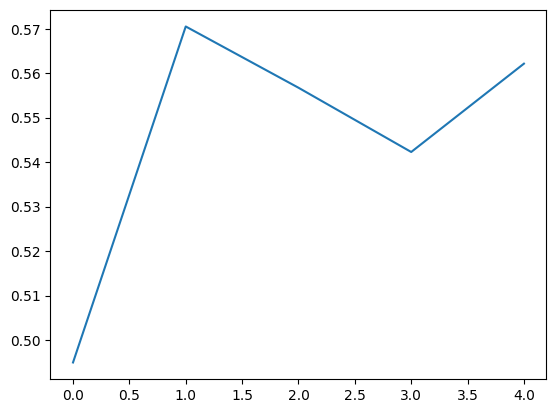

In [16]:
# Plot the performance
import matplotlib.pyplot as plt

split = 'seed42_tr29'
part = all_ckpts[(all_ckpts['model'] == 'flan-t5-xl')
                    & (all_ckpts['split'] == split)]
step_pfm = []
for _, row in part.iterrows():
    ckpt = int(row['ckpt'].split('-')[-1])
    rep_m = row['res_ov']['macro_iou']
    step_pfm.append((ckpt, rep_m))
step_pfm.sort(key = lambda k: k[0])

plt.plot([k[1] for k in step_pfm])

### Only keep the best checkpoint

In [17]:
best_ckpts_alllab = filter_best_ckpt(all_ckpts)
best_ckpts_ood = filter_best_ckpt(all_ckpts_ood)

In [18]:
# Save best macro_f1 score
best_macro_f1 = [(k['model'], k['split'], k['res_ov']['macro_f1']) for k in best_ckpts_alllab]
best_macro_f1_ood = [(k['model'], k['split'], k['res_ov']['macro_f1']) for k in best_ckpts_ood]

In [19]:
save_json(best_macro_f1, 'scripts/plot/save_data/alllab_res_macrof1_splits.json')
save_json(best_macro_f1_ood, 'scripts/plot/save_data/ood_res_macrof1_splits.json')

In [20]:
pd.DataFrame(best_ckpts_alllab).to_pickle('scripts/plot/save_data/best_alllab.pkl')
pd.DataFrame(best_ckpts_ood).to_pickle('scripts/plot/save_data/best_ood.pkl')

## Load Prompting Results

In [111]:
def load_metrics_df_prompt(run_dir):
    "Load results of prompting"
    # Path like: "flan-t5-xl/seed42_tr29/pmt_01"
    run_dir = Path(run_dir)
    lines = []
    for model_p in run_dir.glob('*'):
        for split_p in model_p.glob('*'):
            res_ov = load_json(split_p / 'pmt_01/ov_metrics_ood_sampled.csv')
            res_detail = pd.read_csv(split_p / 'pmt_01/detail_metrics_ood_sampled.csv')
            if model_p.name == 'llama3':
                model_name = 'llama3_chat'
            else:
                model_name = model_p.name
            lines.append((model_name, split_p.name, res_ov, res_detail))
    return pd.DataFrame(lines, columns = ['model', 'split', 'res_ov', 'res_detail'])

In [112]:
best_zs = load_metrics_df_prompt('runs/baseline')
print(len(best_zs))
best_zs.head()

6


,model,split,res_ov,res_detail
0,flan-t5-xl,seed42_tr29,"{'doc_macro_f1': 0.6374265432696498, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...
1,flan-t5-xl,seed128_tr29,"{'doc_macro_f1': 0.7038352405582549, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...
2,flan-t5-xl,seed89_tr29,"{'doc_macro_f1': 0.7766769559191368, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...
3,llama3_chat,seed42_tr29,"{'doc_macro_f1': 0.5263318598431462, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...
4,llama3_chat,seed128_tr29,"{'doc_macro_f1': 0.6428399183603721, 'doc_macr...",q_id macro_p macro_r macro_f1 macro_...


In [113]:
best_zs.to_pickle('scripts/plot/save_data/zs_baseline.pkl')